# Section 0: Initialization

## Libraries & Setup

In [ ]:
import pandas as pd
import random
import numpy as np; np.random.seed(545)
import json
import matplotlib
import matplotlib.pyplot as plt
import glob
import re
import os
from matplotlib import cm
from datetime import datetime

# for cleaning tweets
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Section 1: Loading and Cleaning Dataset
In this section, we will download our dataset and clean it up.

### Connect to Google Drive
First, we want to connect to Google Drive to store our data later.

- This will create a 'senior_design' folder in the drive, as well as a 'modeling_data' folder within it.

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# Create folder to write data to
SENIOR_DESIGN_FOLDER=os.path.join(DRIVE_MOUNT, 'MyDrive', 'senior_design')
PROJECT_FOLDER=os.path.join(SENIOR_DESIGN_FOLDER, 'modeling_data')
os.makedirs(PROJECT_FOLDER, exist_ok=True) # unalter directory if it already exists using "exist_ok" attribute

Mounted at /content/gdrive


### Download the dataset

*Note: You only need to run this part once.*

After connecting to the drive, we download the original dataset. This original dataset is from https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction?select=stock_yfinance_data.csv, which is available for public use. 

As described on the Kaggle website, these dataset contain tweets for top 25 most watched stock tickers on Yahoo Finance from 2021-09-30 to 2022-09-30, as well as the stock market price and volume data for corresponding dates and stocks.

We will be downloading from this file path, which is to a zip file that contains all of the data we will need for now.

- /content/gdrive/MyDrive/senior_design/modeling_data/data.zip





In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

file_path = os.path.join(PROJECT_FOLDER, 'data.zip')

# TODO: Change the sharing setting for the file.
# NOTE: file-id is from the sharing link https://drive.google.com/file/d/{file-id}/view?usp=sharing
if not os.path.isfile(file_path): 
  gdd.download_file_from_google_drive(file_id='1uf7pURfzL2cxw0ZjJ3LGf4gG3ZY8gs8b',
                                    dest_path=file_path)

### Load the data

*Note: You only need to run this part once.*

We need to unzip data.zip.

- This will create a `tweet_data` folder in the root directory and have two files (`stock_tweets.csv` and `stock_yfinance_data.csv`).

In [ ]:
!unzip {file_path}

Archive:  /content/gdrive/MyDrive/senior_design/modeling_data/data.zip
   creating: tweet_data/
  inflating: tweet_data/stock_yfinance_data.csv  
  inflating: __MACOSX/tweet_data/._stock_yfinance_data.csv  
  inflating: tweet_data/stock_tweets.csv  
  inflating: __MACOSX/tweet_data/._stock_tweets.csv  


### Read the data

Now, we read the csv file and load to Pandas dataframe.

We need to reinitialize the datatypes for columns since each they have a default type of Object.

#### Data #1: Stock tweets

In [ ]:
# Set datatypes for each column: Date, Tweet, Stock Name, Company Name
csv_types = {'Date': 'string', 'Tweet': 'string', 'Stock Name': 'string', 'Company Name': 'string'}

stock_tweet_df = pd.read_csv('tweet_data/stock_tweets.csv', index_col=False, dtype=csv_types)
stock_tweet_df.rename(columns={'Date': 'date', 'Tweet': 'tweet_text', 'Stock Name': 'stock_name', 'Company Name': 'company_name'}, inplace=True)

stock_tweet_df

,date,tweet_text,stock_name,company_name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [ ]:
stock_tweet_df.dtypes

date            string
tweet_text      string
stock_name      string
company_name    string
dtype: object

#### Data #2: Stock movement pricings

In [ ]:
# Set datatypes for each column: Date, Tweet, Stock Name, Company Name
csv_types = {'Date': 'string', 'Open': float, 'High': float, 'Low': float, 'Close': float, 'Adj Close': float, 'Volume': int, 'Stock Name': 'string'}

stock_yfinance_df = pd.read_csv('tweet_data/stock_yfinance_data.csv', index_col=False, dtype=csv_types)
stock_yfinance_df.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume', 'Stock Name': 'stock_name'}, inplace=True)

stock_yfinance_df

,date,open,high,low,close,adj_close,volume,stock_name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


### Data Cleaning

Now we will clean the data. This includes checking for any null values and individually pre-processing each twitter text. We want to make the data as clean and consistent as possible so that we can proceed with exploring the data and modeling.

#### Remove `Null` values

In [ ]:
# Deep copy the dataframe
stock_tweet_cleaned_df = stock_tweet_df.copy(deep=True)
stock_yfinance_cleaned_df = stock_yfinance_df.copy(deep=True)

In [ ]:
# Count the NaN values in each column
date_nan_count = stock_tweet_df['date'].isna().sum()
tweet_text_nan_count = stock_tweet_df['tweet_text'].isna().sum()
stock_name_nan_count = stock_tweet_df['stock_name'].isna().sum()
company_name_nan_count = stock_tweet_df['company_name'].isna().sum()

print(tweet_text_nan_count)
print(date_nan_count)
print(stock_name_nan_count)
print(company_name_nan_count)


0
0
0
0


In [ ]:
date_nan_count = stock_yfinance_df['date'].isna().sum()
open_nan_count = stock_yfinance_df['open'].isna().sum()
high_nan_count = stock_yfinance_df['high'].isna().sum()
low_nan_count = stock_yfinance_df['low'].isna().sum()
close_nan_count = stock_yfinance_df['close'].isna().sum()
adj_close_nan_count = stock_yfinance_df['adj_close'].isna().sum()
volume_nan_count = stock_yfinance_df['volume'].isna().sum()
stock_name_nan_count = stock_yfinance_df['stock_name'].isna().sum()

print(date_nan_count)
print(open_nan_count)
print(high_nan_count)
print(low_nan_count)
print(close_nan_count)
print(adj_close_nan_count)
print(volume_nan_count)
print(stock_name_nan_count)

0
0
0
0
0
0
0
0


Since none of the columns have a null value, we can safely skip the step of dropping columns as necessary.

#### Make casing of company and stock names consistent

In [ ]:
# Upper case the stock name and lowercase the company names to maintain the consistency
stock_tweet_cleaned_df['stock_name'] = stock_tweet_df['stock_name'].str.upper()
stock_tweet_cleaned_df['company_name'] = stock_tweet_df['company_name'].str.lower()
stock_tweet_cleaned_df.dtypes
stock_tweet_cleaned_df

,date,tweet_text,stock_name,company_name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"tesla, inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"tesla, inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"tesla, inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"tesla, inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"tesla, inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,xpeng inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,xpeng inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,xpeng inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,xpeng inc.


In [ ]:
# Uppercase the stock name to maintain consistency
stock_yfinance_cleaned_df['stock_name'] = stock_yfinance_df['stock_name'].str.upper()
stock_yfinance_cleaned_df.dtypes
stock_yfinance_cleaned_df

,date,open,high,low,close,adj_close,volume,stock_name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


#### Turn `date` values to datetime objects

In [ ]:
# Change 'date' columns to Date Time Objects. 
stock_tweet_cleaned_df['date'] = pd.to_datetime(stock_tweet_df['date'], errors = 'coerce')
stock_yfinance_cleaned_df['date'] = pd.to_datetime(stock_yfinance_df['date'], errors = 'coerce')

In [ ]:
stock_tweet_cleaned_df.dtypes

date            datetime64[ns, UTC]
tweet_text                   string
stock_name                   string
company_name                 string
dtype: object

In [ ]:
stock_yfinance_cleaned_df.dtypes

date          datetime64[ns]
open                 float64
high                 float64
low                  float64
close                float64
adj_close            float64
volume                 int64
stock_name            string
dtype: object

#### Twitter raw text cleaning

As part of data cleaning, each value in `tweet_text` column will be cleaned. This includes lower-casing the text, removing specific miscellaneous/interfering characters, stopwords, and hyperlinks.

In [ ]:
import re
import string
from nltk.tokenize import TweetTokenizer

def clean_tweet(tweet_text):
    '''
        Preprocesses/cleans each tweet

        Args:
            tweet_text (string): text content of the tweet - this is the 'tweet_text' column value

        Returns:
            tweets_clean ([string]): array of cleaned tokens from the inputted tweet
    '''
    # Lowercase the text
    result = tweet_text.lower()
    # Remove old style retweet text "RT"
    result = re.sub(r'^RT[\s]', '', tweet_text)
    # Remove links
    result = re.sub('<[a][^>]*>(.+?)</[a]>"', 'Link.', result)
    result = re.sub(r'http\S+', '', result)
    # Remove hashtags and other characters
    result = re.sub(r'#', '', result)
    result = re.sub('&gt;', '', result)
    result = re.sub('&#x27;', '\'', result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub('\n', '', result)
    # Remove mentions
    result = re.sub(r'(?i)@[a-z0-9_]+', '', result)

    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False,
                            strip_handles=True, reduce_len=True)
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(result)

    # Import the english stop words list from NLTK
    stopwords_english = stopwords.words('english')

    # Creating a list of words without stopwords and punctuations
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            tweets_clean.append(word)

    return ' '.join(tweets_clean)

In [ ]:
stock_tweet_cleaned_df['tweet_text'] = stock_tweet_df['tweet_text'].apply(clean_tweet)
stock_tweet_cleaned_df

,date,tweet_text,stock_name,company_name
0,2022-09-29 23:41:16+00:00,mainstream media done amazing job brainwashing...,TSLA,"tesla, inc."
1,2022-09-29 23:24:43+00:00,tesla delivery estimates around 364k analysts ...,TSLA,"tesla, inc."
2,2022-09-29 23:18:08+00:00,3 even include 63.0 unvested rsus 6/30 additio...,TSLA,"tesla, inc."
3,2022-09-29 22:40:07+00:00,hahaha still trying stop tesla fsd bro get shi...,TSLA,"tesla, inc."
4,2022-09-29 22:27:05+00:00,stop trying kill kids sad deranged old man,TSLA,"tesla, inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,fastest growing tech stocks market mix fintech...,XPEV,xpeng inc.
80789,2021-10-04 17:05:59+00:00,earnings horizon quick snapshot largest increa...,XPEV,xpeng inc.
80790,2021-10-01 04:43:41+00:00,record delivery results testimony unwavering p...,XPEV,xpeng inc.
80791,2021-10-01 00:03:32+00:00,"delivered 10,412 smart evs sep 2021 reaching m...",XPEV,xpeng inc.


Drop any rows with empty strings in `tweet_text` after cleaning.

In [ ]:
stock_tweet_cleaned_df = stock_tweet_cleaned_df[stock_tweet_cleaned_df['tweet_text'] != '']

stock_tweet_cleaned_df

,date,tweet_text,stock_name,company_name
0,2022-09-29 23:41:16+00:00,mainstream media done amazing job brainwashing...,TSLA,"tesla, inc."
1,2022-09-29 23:24:43+00:00,tesla delivery estimates around 364k analysts ...,TSLA,"tesla, inc."
2,2022-09-29 23:18:08+00:00,3 even include 63.0 unvested rsus 6/30 additio...,TSLA,"tesla, inc."
3,2022-09-29 22:40:07+00:00,hahaha still trying stop tesla fsd bro get shi...,TSLA,"tesla, inc."
4,2022-09-29 22:27:05+00:00,stop trying kill kids sad deranged old man,TSLA,"tesla, inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,fastest growing tech stocks market mix fintech...,XPEV,xpeng inc.
80789,2021-10-04 17:05:59+00:00,earnings horizon quick snapshot largest increa...,XPEV,xpeng inc.
80790,2021-10-01 04:43:41+00:00,record delivery results testimony unwavering p...,XPEV,xpeng inc.
80791,2021-10-01 00:03:32+00:00,"delivered 10,412 smart evs sep 2021 reaching m...",XPEV,xpeng inc.


In [ ]:
stock_tweet_cleaned_df.dtypes

date            datetime64[ns, UTC]
tweet_text                   object
stock_name                   string
company_name                 string
dtype: object

In [ ]:
# Change `tweet_text` back to string type
stock_tweet_cleaned_df['tweet_text'] = stock_tweet_cleaned_df.tweet_text.astype('string')

<ipython-input-20-61cd806d3f79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_tweet_cleaned_df['tweet_text'] = stock_tweet_cleaned_df.tweet_text.astype('string')


In [ ]:
stock_tweet_cleaned_df.dtypes

date            datetime64[ns, UTC]
tweet_text                   string
stock_name                   string
company_name                 string
dtype: object

### Save the data

Now that we have cleaned our dataset, let's save it as a csv file so that we will not need to rerun these cells again next time.

In [ ]:
cleaned_stock_tweet_data_path = 'gdrive/MyDrive/senior_design/modeling_data/cleaned_stock_tweet_data.csv'
stock_tweet_cleaned_df.to_csv(cleaned_stock_tweet_data_path)

In [ ]:
cleaned_stock_yfinance_data_path = 'gdrive/MyDrive/senior_design/modeling_data/cleaned_stock_yfinance_data.csv'
stock_yfinance_cleaned_df.to_csv(cleaned_stock_yfinance_data_path)

# Section 2: Exploring Dataset and Feature Engineering

In this section, we will be doing exploratory data analysis and feature engineering to get a better understanding of our data and prepare for building our model later.

## Pandas vs. Spark

We have ~80k rows of data for stock tweets and ~6k for stock movement pricings, which is not too large. However, before we start analyzing the data, we will still experiment and see if using Spark to distribute our data will speed up the process significantly.

If Pandas operations take too long, we want to take advantage of Spark; at the same time, however, we don't want to unnecessarily use Spark and waste resources.

### Spark initialization

First, let's connect to Spark!

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
%load_ext sparkmagic.magics

As always, installing all of the necessary packages.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f
import os
os.environ['SPARK_HOME'] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
#misc
import gc
import warnings

# JSON parsing
import json

# SQLite RDBMS
import sqlite3

import os
os.environ['SPARK_HOME'] = "/content/spark-3.3.1-bin-hadoop3"
import pyspark
from pyspark.sql import SQLContext

Finally, let's start our Spark session!

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

**Note: We added the cell below after seeing that SparkSQL was running slower than PandaSQL. We thought that by making the partitions smaller from 200 (default value) to 10, perhaps the process will get faster since there will be less overhead.

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", 10)

### Pandas setup

Next, we will compute the same query with PandaSQL.

In [ ]:
# download pandasql
!pip install pandasql
import pandasql as ps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=ea12d738215e061a49d1f0573331de8bbdc4a8ab0092d36f90c0668589257ef4
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


### Load data

Now that we have Spark session fully initialized, let's load the cleaned_stock_tweet_data.csv file into the Spark dataframe.

In [ ]:
spark_reader = spark.read.option("header", True).format("csv")
stock_tweet_sdf = spark_reader.load(cleaned_stock_tweet_data_path)

In [ ]:
stock_tweet_sdf.createOrReplaceTempView('stock_tweet_view')
stock_tweet_sdf.show(10)
stock_tweet_sdf.dtypes

+---+--------------------+--------------------+----------+------------+
|_c0|                date|          tweet_text|stock_name|company_name|
+---+--------------------+--------------------+----------+------------+
|  0|2022-09-29 23:41:...|mainstream media ...|      TSLA| tesla, inc.|
|  1|2022-09-29 23:24:...|tesla delivery es...|      TSLA| tesla, inc.|
|  2|2022-09-29 23:18:...|3 even include 63...|      TSLA| tesla, inc.|
|  3|2022-09-29 22:40:...|hahaha still tryi...|      TSLA| tesla, inc.|
|  4|2022-09-29 22:27:...|stop trying kill ...|      TSLA| tesla, inc.|
|  6|2022-09-29 22:24:...|years viciously s...|      TSLA| tesla, inc.|
|  7|2022-09-29 22:23:...|nio i'm money mea...|      TSLA| tesla, inc.|
|  8|2022-09-29 22:23:...|50 likes spy tsla...|      TSLA| tesla, inc.|
|  9|2022-09-29 22:15:...|powerwalls waterp...|      TSLA| tesla, inc.|
| 10|2022-09-29 21:58:...|tomorrow tesla ts...|      TSLA| tesla, inc.|
+---+--------------------+--------------------+----------+------

[('_c0', 'string'),
 ('date', 'string'),
 ('tweet_text', 'string'),
 ('stock_name', 'string'),
 ('company_name', 'string')]

In [ ]:
# Run this cell to reload the dataframe from the csv file
csv_stock_tweet_types = {'index': int, 'date': 'string', 'tweet_text': 'string', 'stock_name': 'string', 'company_name': 'string'}
loaded_stock_tweet_path = 'gdrive/MyDrive/senior_design/modeling_data/cleaned_stock_tweet_data.csv'
stock_tweet_df = pd.read_csv(loaded_stock_tweet_path, dtype=csv_stock_tweet_types)

In [ ]:
stock_tweet_df.drop(stock_tweet_df.columns[0],axis=1,inplace=True)
stock_tweet_df

,date,tweet_text,stock_name,company_name
0,2022-09-29 23:41:16+00:00,mainstream media done amazing job brainwashing...,TSLA,"tesla, inc."
1,2022-09-29 23:24:43+00:00,tesla delivery estimates around 364k analysts ...,TSLA,"tesla, inc."
2,2022-09-29 23:18:08+00:00,3 even include 63.0 unvested rsus 6/30 additio...,TSLA,"tesla, inc."
3,2022-09-29 22:40:07+00:00,hahaha still trying stop tesla fsd bro get shi...,TSLA,"tesla, inc."
4,2022-09-29 22:27:05+00:00,stop trying kill kids sad deranged old man,TSLA,"tesla, inc."
...,...,...,...,...
80749,2021-10-07 17:11:57+00:00,fastest growing tech stocks market mix fintech...,XPEV,xpeng inc.
80750,2021-10-04 17:05:59+00:00,earnings horizon quick snapshot largest increa...,XPEV,xpeng inc.
80751,2021-10-01 04:43:41+00:00,record delivery results testimony unwavering p...,XPEV,xpeng inc.
80752,2021-10-01 00:03:32+00:00,"delivered 10,412 smart evs sep 2021 reaching m...",XPEV,xpeng inc.


### Performance comparison

For comparison, we will look specifically at their performance on SQL queries. The sample query we will use involves counting tweets about each company, published between 2022-01-01 and 2022-03-01.

We will first start out by testing with Spark SQL

In [ ]:
import time
spark_sql = '''
                SELECT selected_tweets.company_name, COUNT(*) AS count
                FROM 
                  (SELECT *
                   FROM stock_tweet_view
                   WHERE stock_tweet_view.date >= '2022-01-01 00:00:00+00:00' AND 
                         stock_tweet_view.date <= '2022-03-01 00:00:00+00:00'
                  ) AS selected_tweets
                GROUP BY selected_tweets.company_name
                ORDER BY count DESC
             '''
# start the timer
start_time = time.time()
sqlContext.sql(spark_sql).show()
# calculate the time difference
spark_time = time.time() - start_time

+--------------------+-----+
|        company_name|count|
+--------------------+-----+
|         tesla, inc.| 6523|
|taiwan semiconduc...| 2586|
|meta platforms, inc.|  960|
|procter & gamble ...|  956|
|    amazon.com, inc.|  956|
|microsoft corpora...|  956|
|          apple inc.|  775|
|            nio inc.|  535|
|advanced micro de...|  407|
|       netflix, inc.|  335|
|       alphabet inc.|  307|
|paypal holdings, ...|  264|
|the walt disney c...|  132|
|  the boeing company|   81|
|   intel corporation|   55|
|the coca-cola com...|   46|
|          xpeng inc.|   45|
|costco wholesale ...|   44|
|       zscaler, inc.|   39|
|    salesforce, inc.|   36|
+--------------------+-----+
only showing top 20 rows



In [ ]:
pandas_sql = '''
                SELECT selected_tweets.company_name, COUNT(*) AS count
                FROM 
                  (SELECT *
                   FROM stock_tweet_df
                   WHERE stock_tweet_df.date >= '2022-01-01 00:00:00+00:00' AND 
                         stock_tweet_df.date <= '2022-03-01 00:00:00+00:00'
                  ) AS selected_tweets
                GROUP BY selected_tweets.company_name
                ORDER BY count DESC
             '''
# start the timer
start_time = time.time()
movies_test_df = ps.sqldf(pandas_sql, locals())
# calculate the time difference
pandas_time = time.time() - start_time
movies_test_df

,company_name,count
0,"tesla, inc.",6523
1,taiwan semiconductor manufacturing company lim...,2586
2,"meta platforms, inc.",960
3,procter & gamble company,956
4,microsoft corporation,956
5,"amazon.com, inc.",956
6,apple inc.,775
7,nio inc.,535
8,"advanced micro devices, inc.",407
9,"netflix, inc.",335


In [ ]:
# Find the ratio between the time it took for pandas and spark
# If ratio > 1, spark is faster. If ratio < 1, pandas is faster. If ratio = 1, they took the same time.
time_ratio = pandas_time/spark_time
time_ratio

0.5007439969835474

Interestingly, we see that Pandas is actually faster than Spark. It takes almost half the time that Spark takes, which may be due to our dataset being too small to fully take advantage of distributing the data

To further analyze, we try changing the number of partitions for Spark from 200 to 10, in an attempt to decrease the overhead work. However, this results in the similar ratio as before. Thus, we note that **Pandas is sufficient for our dataset**, as the significant overhead Spark adds for its functionalities, such as parallelism and fault tolerance, is not worth according to the ratio we obtain above.

## Exploratory Data Analysis

### Load Data

We will load the data as dataframes from the csv files that we created and saved in Section 1.

In [ ]:
# Run this cell to reload the dataframe from the csv file
csv_stock_tweet_types = {'index': int, 'date': 'string', 'tweet_text': 'string', 'stock_name': 'string', 'company_name': 'string'}
loaded_stock_tweet_path = 'gdrive/MyDrive/senior_design/modeling_data/cleaned_stock_tweet_data.csv'
stock_tweet_df = pd.read_csv(loaded_stock_tweet_path, dtype=csv_stock_tweet_types)

csv_stock_yfinance_types = {'Date': 'string', 'Open': float, 'High': float, 'Low': float, 'Close': float, 'Adj Close': float, 'Volume': int, 'Stock Name': 'string'}
loaded_stock_yfinance_path = 'gdrive/MyDrive/senior_design/modeling_data/cleaned_stock_yfinance_data.csv'
stock_yfinance_df = pd.read_csv(loaded_stock_yfinance_path, dtype=csv_stock_yfinance_types)

In [ ]:
print(stock_tweet_df.dtypes)
stock_tweet_df

Unnamed: 0       int64
date            string
tweet_text      string
stock_name      string
company_name    string
dtype: object


,Unnamed: 0,date,tweet_text,stock_name,company_name
0,0,2022-09-29 23:41:16+00:00,mainstream media done amazing job brainwashing...,TSLA,"tesla, inc."
1,1,2022-09-29 23:24:43+00:00,tesla delivery estimates around 364k analysts ...,TSLA,"tesla, inc."
2,2,2022-09-29 23:18:08+00:00,3 even include 63.0 unvested rsus 6/30 additio...,TSLA,"tesla, inc."
3,3,2022-09-29 22:40:07+00:00,hahaha still trying stop tesla fsd bro get shi...,TSLA,"tesla, inc."
4,4,2022-09-29 22:27:05+00:00,stop trying kill kids sad deranged old man,TSLA,"tesla, inc."
...,...,...,...,...,...
80749,80788,2021-10-07 17:11:57+00:00,fastest growing tech stocks market mix fintech...,XPEV,xpeng inc.
80750,80789,2021-10-04 17:05:59+00:00,earnings horizon quick snapshot largest increa...,XPEV,xpeng inc.
80751,80790,2021-10-01 04:43:41+00:00,record delivery results testimony unwavering p...,XPEV,xpeng inc.
80752,80791,2021-10-01 00:03:32+00:00,"delivered 10,412 smart evs sep 2021 reaching m...",XPEV,xpeng inc.


In [ ]:
print(stock_yfinance_df.dtypes)
stock_yfinance_df

Unnamed: 0      int64
date           object
open          float64
high          float64
low           float64
close         float64
adj_close     float64
volume          int64
stock_name     object
dtype: object


,Unnamed: 0,date,open,high,low,close,adj_close,volume,stock_name
0,0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...,...
6295,6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


As we can see, there is a `Unnamed: 0` column, which is meaningless. Let's drop that column for both dataframes.

In [ ]:
stock_tweet_df.drop(stock_tweet_df.columns[0],axis=1,inplace=True)

In [ ]:
stock_yfinance_df.drop(stock_yfinance_df.columns[0],axis=1,inplace=True)

### Plotting Graphs

First things first, let's install seaborn package to create figures later.

In [ ]:
!pip install seaborn --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns

Now we will display portions of the data in a series of graphs to gain a better understanding of some of the categorical data and visualize the spread before modeling.

First, we will look at the companies.



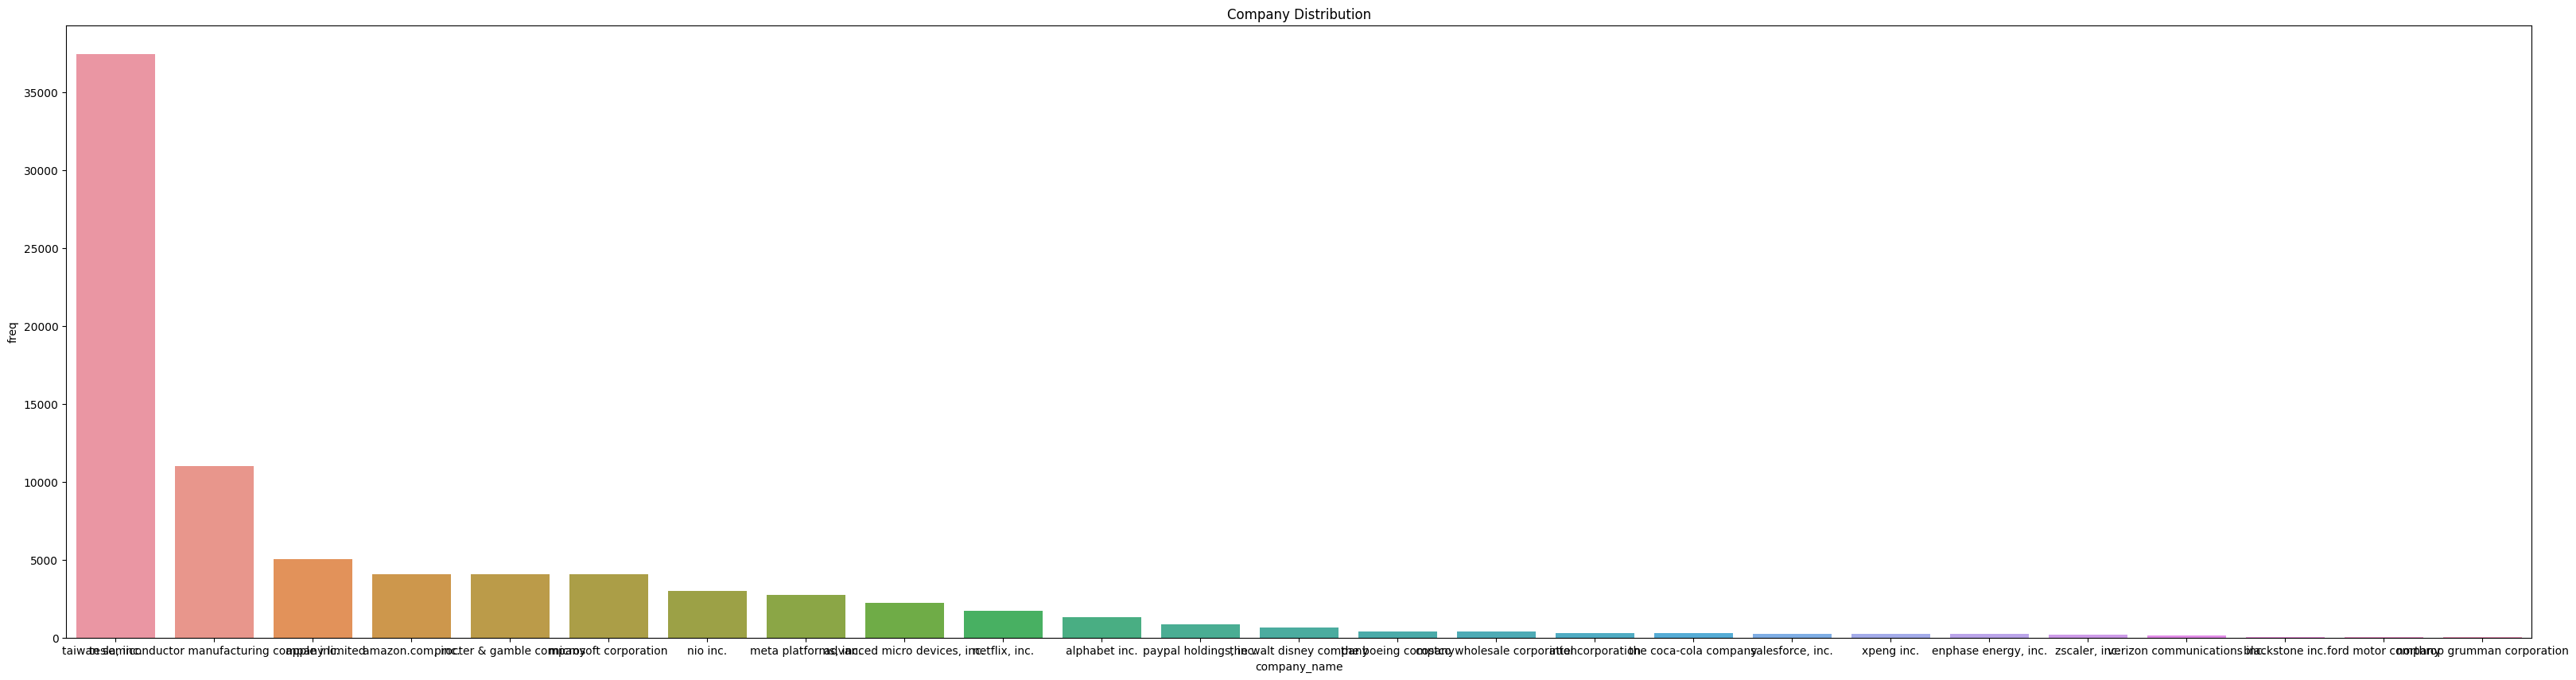

In [ ]:
plt.figure(figsize=(40, 10))
stock_tweet_df_company = stock_tweet_df.value_counts(['company_name']).reset_index(name='freq')
sns.barplot(x='company_name', y='freq' , data=stock_tweet_df_company)
plt.title('Company Distribution')
plt.show()

Next, we will dive deeper into our sentiment analysis findings and see what observations we can make.

In [ ]:
stock_tweet_df

,date,tweet_text,stock_name,company_name
0,2022-09-29 23:41:16+00:00,mainstream media done amazing job brainwashing...,TSLA,"tesla, inc."
1,2022-09-29 23:24:43+00:00,tesla delivery estimates around 364k analysts ...,TSLA,"tesla, inc."
2,2022-09-29 23:18:08+00:00,3 even include 63.0 unvested rsus 6/30 additio...,TSLA,"tesla, inc."
3,2022-09-29 22:40:07+00:00,hahaha still trying stop tesla fsd bro get shi...,TSLA,"tesla, inc."
4,2022-09-29 22:27:05+00:00,stop trying kill kids sad deranged old man,TSLA,"tesla, inc."
...,...,...,...,...
80749,2021-10-07 17:11:57+00:00,fastest growing tech stocks market mix fintech...,XPEV,xpeng inc.
80750,2021-10-04 17:05:59+00:00,earnings horizon quick snapshot largest increa...,XPEV,xpeng inc.
80751,2021-10-01 04:43:41+00:00,record delivery results testimony unwavering p...,XPEV,xpeng inc.
80752,2021-10-01 00:03:32+00:00,"delivered 10,412 smart evs sep 2021 reaching m...",XPEV,xpeng inc.


In [ ]:
# NEED TO FIX: ERROR SHOWING BC I MOVED SENTIMENT ANALYSIS
sns.displot(data=stock_tweet_df, x='tweet_sentiment_score')
plt.title("Spread of Sentiment Across Tweets")

ValueError: ignored

Next, it would be interesting to see if we can see any initial trends between companies and sentiment analysis.

In [ ]:
# Perform log transformation - found that it doesn't improve anything so ignore.
# stock_tweet_df['tweet_sentiment_score_log'] = np.log(stock_tweet_df['tweet_sentiment_score'] + 1)
sns.boxplot(data=stock_tweet_df, x='company_name', y='tweet_sentiment_score')
plt.title("Sentiment Analysis for Companies")

ValueError: ignored

## Feature Engineering

Currently, there are two separate datasets for stock tweets and stock movements. Before merging the two, we will first calculate sentiment score of each tweet and then drop the `tweet_text` column. 



### Sentiment analysis

Looking at the `tweet_text` column, we see that its values are not very useful as a feature currently.

Let's further study the `tweet_text` column by doing a sentiment analysis.

In [ ]:
# installing Afinn package
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=894c83d89dbca34fb6c8b093750410caa873e3ca47c3bc9502b4e32d3642322a
  Stored in directory: /root/.cache/pip/wheels/79/91/ee/8374d9bc8c6c0896a2db75afdfd63d43653902407a0e76cd94
Successfully built afinn


In [ ]:
# set up afinn 
from afinn import Afinn
afinn = Afinn(language='en')
stock_tweet_df.dtypes

date            string
tweet_text      string
stock_name      string
company_name    string
dtype: object

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("stopwords")
nltk.download("vader_lexicon")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Give sentiment score for each tweet
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_analyze(t):
    sent_dict = sent_analyzer.polarity_scores(t)

    return sent_dict["compound"]

stock_tweet_df['tweet_sentiment_score'] = stock_tweet_df['tweet_text'].apply(sentiment_analyze)

In [ ]:
stock_tweet_df.dtypes

date                      string
tweet_text                string
stock_name                string
company_name              string
tweet_sentiment_score    float64
dtype: object

In [ ]:
stock_tweet_df

,date,tweet_text,stock_name,company_name,tweet_sentiment_score
0,2022-09-29 23:41:16+00:00,mainstream media done amazing job brainwashing...,TSLA,"tesla, inc.",0.0772
1,2022-09-29 23:24:43+00:00,tesla delivery estimates around 364k analysts ...,TSLA,"tesla, inc.",0.0000
2,2022-09-29 23:18:08+00:00,3 even include 63.0 unvested rsus 6/30 additio...,TSLA,"tesla, inc.",0.2960
3,2022-09-29 22:40:07+00:00,hahaha still trying stop tesla fsd bro get shi...,TSLA,"tesla, inc.",-0.7096
4,2022-09-29 22:27:05+00:00,stop trying kill kids sad deranged old man,TSLA,"tesla, inc.",-0.8750
...,...,...,...,...,...
80749,2021-10-07 17:11:57+00:00,fastest growing tech stocks market mix fintech...,XPEV,xpeng inc.,0.1779
80750,2021-10-04 17:05:59+00:00,earnings horizon quick snapshot largest increa...,XPEV,xpeng inc.,0.3818
80751,2021-10-01 04:43:41+00:00,record delivery results testimony unwavering p...,XPEV,xpeng inc.,0.4215
80752,2021-10-01 00:03:32+00:00,"delivered 10,412 smart evs sep 2021 reaching m...",XPEV,xpeng inc.,0.5423


In [ ]:
stock_tweet_df.drop(columns=['tweet_text'],axis=1,inplace=True)
stock_tweet_df

KeyError: ignored

### Group by date and company

We will create 1:1 relationship between data in `stock_tweet_df` to `stock_yfinance_df`. 

Since date in `stock_tweet_df` is specified to seconds while it is to days in `stock_yfinance_df`, let's change the `date` column values in `stock_tweet_df` so that it is rounded to days. 

In [ ]:
stock_tweet_df['date'] = pd.to_datetime(stock_tweet_df['date'], errors = 'coerce')
stock_tweet_df.dtypes

date                     datetime64[ns, UTC]
stock_name                            string
company_name                          string
tweet_sentiment_score                float64
dtype: object

In [ ]:
stock_tweet_df['date'] = stock_tweet_df['date'].dt.date
stock_tweet_df

AttributeError: ignored

Next, let's group the data by `stock_name` and `date` and find the average sentiment score.

In [ ]:
averaged_stock_tweet_df = stock_tweet_df.groupby(['stock_name', 'date'], as_index=False)['tweet_sentiment_score'].mean()
averaged_stock_tweet_df

,stock_name,date,tweet_sentiment_score
0,AAPL,2021-09-30,0.171843
1,AAPL,2021-10-01,0.267018
2,AAPL,2021-10-02,-0.004475
3,AAPL,2021-10-03,0.822500
4,AAPL,2021-10-04,0.063420
...,...,...,...
5905,ZS,2022-09-18,0.784500
5906,ZS,2022-09-21,0.440400
5907,ZS,2022-09-27,-0.153100
5908,ZS,2022-09-28,0.381800


### Merge two datasets

Now, we are ready to merge two datasets. We will be merging by two columns: `date` and `stock_name`. 

In [ ]:
averaged_stock_tweet_df

,stock_name,date,tweet_sentiment_score
0,AAPL,2021-09-30,0.171843
1,AAPL,2021-10-01,0.267018
2,AAPL,2021-10-02,-0.004475
3,AAPL,2021-10-03,0.822500
4,AAPL,2021-10-04,0.063420
...,...,...,...
5905,ZS,2022-09-18,0.784500
5906,ZS,2022-09-21,0.440400
5907,ZS,2022-09-27,-0.153100
5908,ZS,2022-09-28,0.381800


In [ ]:
averaged_stock_tweet_df['stock_name'] = averaged_stock_tweet_df.stock_name.astype('string')
averaged_stock_tweet_df['date'] = averaged_stock_tweet_df.date.astype('string')

In [ ]:
averaged_stock_tweet_df.dtypes

stock_name                string
date                      string
tweet_sentiment_score    float64
dtype: object

In [ ]:
stock_yfinance_df

,date,open,high,low,close,adj_close,volume,stock_name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [ ]:
stock_yfinance_df['stock_name'] = stock_yfinance_df.stock_name.astype('string')
stock_yfinance_df['date'] = stock_yfinance_df.date.astype('string')

In [ ]:
stock_yfinance_df.dtypes

date           string
open          float64
high          float64
low           float64
close         float64
adj_close     float64
volume          int64
stock_name     string
dtype: object

In [ ]:
merged_df = pd.merge(left=averaged_stock_tweet_df, right=stock_yfinance_df, left_on=['date', 'stock_name'], right_on=['date', 'stock_name'], how="inner")
merged_df.sort_values(by = ['stock_name', 'date'], ascending = [True, True], na_position = 'first')
merged_df

,stock_name,date,tweet_sentiment_score,open,high,low,close,adj_close,volume
0,AAPL,2021-09-30,0.171843,143.660004,144.380005,141.279999,141.500000,140.478485,89056700
1,AAPL,2021-10-01,0.267018,141.899994,142.919998,139.110001,142.649994,141.620163,94639600
2,AAPL,2021-10-04,0.063420,141.759995,142.210007,138.270004,139.139999,138.135513,98322000
3,AAPL,2021-10-05,0.274080,139.490005,142.240005,139.360001,141.110001,140.091278,80861100
4,AAPL,2021-10-06,0.217630,139.470001,142.149994,138.369995,142.000000,140.974869,83221100
...,...,...,...,...,...,...,...,...,...
4179,ZS,2022-09-14,0.000000,182.149994,183.779999,177.610001,182.979996,182.979996,2408900
4180,ZS,2022-09-21,0.440400,173.020004,179.889999,171.740005,171.880005,171.880005,1901800
4181,ZS,2022-09-27,-0.153100,163.910004,166.399994,159.990005,163.210007,163.210007,1718300
4182,ZS,2022-09-28,0.381800,164.000000,169.539993,162.634995,168.779999,168.779999,1723100


# Section 3: Prepare for training

## Preparing Data


We will a new column called `intraday price change`, which will be the difference between open and closing.

In [ ]:
merged_df['intraday_price_change'] = merged_df['open'] - merged_df['close']
merged_df

,stock_name,date,tweet_sentiment_score,open,high,low,close,adj_close,volume,intraday_price_change
0,AAPL,2021-09-30,0.171843,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,2.160004
1,AAPL,2021-10-01,0.267018,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,-0.750000
2,AAPL,2021-10-04,0.063420,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,2.619995
3,AAPL,2021-10-05,0.274080,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,-1.619995
4,AAPL,2021-10-06,0.217630,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,-2.529999
...,...,...,...,...,...,...,...,...,...,...
4179,ZS,2022-09-14,0.000000,182.149994,183.779999,177.610001,182.979996,182.979996,2408900,-0.830002
4180,ZS,2022-09-21,0.440400,173.020004,179.889999,171.740005,171.880005,171.880005,1901800,1.139999
4181,ZS,2022-09-27,-0.153100,163.910004,166.399994,159.990005,163.210007,163.210007,1718300,0.699997
4182,ZS,2022-09-28,0.381800,164.000000,169.539993,162.634995,168.779999,168.779999,1723100,-4.779999


Based on the price change, we will populate a new column `intraday price movement`, which will be 1 if `intraday price change` is positive and 0 if negative.

In [ ]:
def get_price_movement(change):
  return 1 if change > 0 else 0

In [ ]:
merged_df['intraday_price_movement'] = merged_df['intraday_price_change'].apply(get_price_movement)
merged_df

,stock_name,date,tweet_sentiment_score,open,high,low,close,adj_close,volume,intraday_price_change,intraday_price_movement
0,AAPL,2021-09-30,0.171843,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,2.160004,1
1,AAPL,2021-10-01,0.267018,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,-0.750000,0
2,AAPL,2021-10-04,0.063420,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,2.619995,1
3,AAPL,2021-10-05,0.274080,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,-1.619995,0
4,AAPL,2021-10-06,0.217630,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,-2.529999,0
...,...,...,...,...,...,...,...,...,...,...,...
4179,ZS,2022-09-14,0.000000,182.149994,183.779999,177.610001,182.979996,182.979996,2408900,-0.830002,0
4180,ZS,2022-09-21,0.440400,173.020004,179.889999,171.740005,171.880005,171.880005,1901800,1.139999,1
4181,ZS,2022-09-27,-0.153100,163.910004,166.399994,159.990005,163.210007,163.210007,1718300,0.699997,1
4182,ZS,2022-09-28,0.381800,164.000000,169.539993,162.634995,168.779999,168.779999,1723100,-4.779999,0


### Split data into train, validation, and test
Finally, we will split the data into train, validation, and test sets

In [ ]:
label = merged_df['tweet_sentiment_score']
feature = merged_df[['stock_name', 'tweet_sentiment_score']].copy()
label

0       0.171843
1       0.267018
2       0.063420
3       0.274080
4       0.217630
          ...   
4179    0.000000
4180    0.440400
4181   -0.153100
4182    0.381800
4183   -0.648600
Name: tweet_sentiment_score, Length: 4184, dtype: float64

Since we will be doing hyperparameter tuning later with different models and parameters, we want to have a validation dataset as well.

- We will first designate 0.75 of the data for training and split up the rest of the data for so that test set has 0.1 of the original dataset and validation set has 0.15.

In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3138, 2)
(627, 2)
(419, 2)
(3138,)
(627,)
(419,)


In [ ]:
y_test

240     0.152220
4151    0.612400
3335   -0.306400
708     0.157357
2094    0.057483
          ...   
3867    0.255122
1706    0.272233
1954    0.382450
1017   -0.017200
3866    0.413540
Name: tweet_sentiment_score, Length: 419, dtype: float64

### Resampling

Now, let's make sure that the train dataset is **balanced**, where the number of datapoints for other companies are comparable to Tesla. Otherwise, our model may become too biased towards one class.

First let's check how many tweets are there for each company at the moment in our training set. 

In [ ]:
grouped_x_train = x_train.value_counts(['stock_name']).reset_index(name='freq')
grouped_x_train

,stock_name,freq
0,NIO,205
1,MSFT,197
2,AMZN,196
3,TSM,189
4,TSLA,189
5,PG,184
6,AMD,181
7,AAPL,170
8,META,167
9,NFLX,167


Clearly, there is some balance for some companies. Let's use resampling to mitigate this issue. Given that there are not many successful movies, we will use oversampling to add more data for those particular companies.

Let's download the imblearn package first.

In [ ]:
!pip install imblearn
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Section 3: Machine Learning - Unsupervised and Supervised Learning

In this section, we will perform unsupervised and supervised learning for our model. To refresh our minds with what our model will do, our model will do a binary classification where it will predict stock movement based on sentimental analysis. 

In [ ]:
x_train_data_path = 'gdrive/MyDrive/senior_design/modeling_data/x_train.csv'
x_train.to_csv(x_train_data_path)

In [ ]:
y_train_data_path = 'gdrive/MyDrive/senior_design/modeling_data/y_train.csv'
y_train.to_csv(y_train_data_path)

In [ ]:
x_val_data_path = 'gdrive/MyDrive/senior_design/modeling_data/x_val.csv'
x_val.to_csv(x_val_data_path)

In [ ]:
y_val_data_path = 'gdrive/MyDrive/senior_design/modeling_data/y_val.csv'
y_val.to_csv(y_val_data_path)

In [ ]:
x_test_data_path = 'gdrive/MyDrive/senior_design/modeling_data/x_test.csv'
x_test.to_csv(x_test_data_path)

In [ ]:
y_test_data_path = 'gdrive/MyDrive/senior_design/modeling_data/y_test.csv'
y_test.to_csv(y_test_data_path)

In [ ]:
y_test

## Modeling

As always, make sure to install all necessary libraries

In [ ]:
import random
import numpy as np 
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
np.random.seed(545)

Let's also make sure to connect to the Drive if we haven't yet



In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# Create folder to write data to
SENIOR_DESIGN_FOLDER=os.path.join(DRIVE_MOUNT, 'MyDrive', 'senior_design')
PROJECT_FOLDER=os.path.join(SENIOR_DESIGN_FOLDER, 'modeling_data')
os.makedirs(PROJECT_FOLDER, exist_ok=True) # unalter directory if it already exists using "exist_ok" attribute

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Before we start modeling, we need to retrieve all of the train, dev, and test dataset we saved to our drive earlier

Skip to this cell if you have already downloaded the dataset before. Otherwise, run the cells below.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "x_train.csv")

gdd.download_file_from_google_drive(file_id='1w6ze80NkAdadl-Rp2D0389QNR4jpyTZp',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "x_val.csv")

gdd.download_file_from_google_drive(file_id='1-7WwyFrATQYdxMxpTHRHG2ovELBazwkn',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "x_test.csv")

gdd.download_file_from_google_drive(file_id='1-BRBZmk_PFOWBlKnxS4R7VW_2SoXwFdx',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "y_train.csv")

gdd.download_file_from_google_drive(file_id='1-1k29Gs-7QL6EXwjyzdbjW_mypMGtdJM',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "y_val.csv")

gdd.download_file_from_google_drive(file_id='1-9oxZQmV5NI5i83FEFfDZ_PAaCQ_CCAG',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "y_test.csv")

gdd.download_file_from_google_drive(file_id='1-CyiUOo4s9GYrKuw2xIynrKWx1SgT3CM',
                                  dest_path=file_path)

If all of the dataset are already downloaded in the drive, just run the cell below.

In [ ]:
x_train = pd.read_csv('/content/gdrive/My Drive/senior_design/modeling_data/x_train.csv')
x_val = pd.read_csv('/content/gdrive/My Drive/senior_design/modeling_data/x_val.csv')
x_test = pd.read_csv('/content/gdrive/My Drive/senior_design/modeling_data/x_test.csv')
y_train = pd.read_csv('/content/gdrive/My Drive/senior_design/modeling_data/y_train.csv')
y_val = pd.read_csv('/content/gdrive/My Drive/senior_design/modeling_data/y_val.csv')
y_test = pd.read_csv('/content/gdrive/My Drive/senior_design/modeling_data/y_test.csv')

In [ ]:
y_test

,Unnamed: 0,intraday_price_movement
0,2204,0
1,4095,0
2,4074,0
3,3917,1
4,1925,0
...,...,...
414,825,1
415,1846,0
416,3002,0
417,3393,1


Ah, we see that a new column "Unnamed: 0" was added when converting the csv file. Let's make sure to drop that column for all dataframes.

In [ ]:
x_train.drop(columns=['Unnamed: 0'], inplace=True)
x_val.drop(columns=['Unnamed: 0'], inplace=True)
x_test.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_val.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
x_train

,stock_name,tweet_sentiment_score
0,AAPL,0.203610
1,NIO,0.142075
2,INTC,0.125000
3,TSLA,0.082441
4,PG,0.274125
...,...,...
3133,XPEV,-0.340000
3134,KO,0.000000
3135,F,-0.624900
3136,COST,0.659700


In [ ]:
y_train

,intraday_price_movement
0,0
1,0
2,1
3,0
4,0
...,...
3133,1
3134,0
3135,0
3136,0


Trying the model only for Tesla

In [ ]:
x_train = x_train

In [ ]:
x_train.drop(columns=['stock_name'], inplace=True)
x_val.drop(columns=['stock_name'], inplace=True)
x_test.drop(columns=['stock_name'], inplace=True)

In [ ]:
x_train

,tweet_sentiment_score
0,-0.116676
1,0.479200
2,0.000000
3,0.210750
4,0.151990
...,...
3133,0.000000
3134,0.189150
3135,0.371450
3136,-0.421500


In [ ]:
y_train

,intraday_price_movement
0,1
1,0
2,0
3,0
4,1
...,...
3133,0
3134,1
3135,0
3136,1


In [ ]:
def get_price_movement(change):
  return 1 if change > 0 else 0

In [ ]:
x_train_new = x_train
x_train_new['tweet_sentiment_score'] = x_train_new['tweet_sentiment_score'].apply(lambda x: get_price_movement(x))

In [ ]:
x_train_new

,tweet_sentiment_score
0,0
1,1
2,0
3,1
4,1
...,...
3133,0
3134,1
3135,1
3136,0


In [ ]:
x_val_new = x_val
x_val_new['tweet_sentiment_score'] = x_val_new['tweet_sentiment_score'].apply(lambda x: get_price_movement(x))
x_val_new

,tweet_sentiment_score
0,1
1,1
2,1
3,1
4,1
...,...
622,1
623,1
624,0
625,0


Now, we will start experimenting with various models and do hyperparameter tuning to find the most optimal model for our purpose. We will use the validation dataset to compare results among these models and choose the best one. Then, we will run our best model on our test set.

We will use following models: bagged decision tree classifier, random forest classifier, logistic regression, and support vector machine.

### Logistic Regression
We will explore logistic regression next, which is another well known model for binary classification



> Indented block



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression(max_iter=200, penalty="l2", C=1, solver='lbfgs').fit(x_train_new, np.ravel(y_train))
y_pred_lr = lr.predict(x_val_new)

In [ ]:
metrics.accuracy_score(y_val, y_pred_lr)

0.5039872408293461

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf_u = AdaBoostClassifier(n_estimators=200, random_state=0)
clf_u.fit(x_train, np.ravel(y_train))
     

AdaBoostClassifier(n_estimators=200, random_state=0)

In [ ]:

clf_pred = clf_u.predict(x_val_new)
metrics.accuracy_score(y_val, clf_pred)
     

0.5039872408293461

In [ ]:

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=300, max_samples=30, max_depth=30, max_features=None, oob_score=True, class_weight="balanced")
random_forest.fit(x_train, np.ravel(y_train))
     

RandomForestClassifier(class_weight='balanced', max_depth=30, max_features=None,
                       max_samples=30, n_estimators=300, oob_score=True)

In [ ]:
random_forest_pred = random_forest.predict(x_val)
metrics.accuracy_score(y_val, random_forest_pred)

0.5039872408293461

In [ ]:
x_val

,tweet_sentiment_score
0,1
1,1
2,1
3,1
4,1
...,...
622,1
623,1
624,0
625,0
